# Simple iteration for systems of linear equations

First, generate a random diagonally dominant matrix, for testing.

In [1]:
import numpy as np
rndm = np.random.RandomState(1234)

n = 10
A = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b = rndm.uniform(size=n)

# I.  Jacobi iteration

Given

$$
A x = b
$$

separate the diagonal part $D$,

$$ A = D + (A - D) $$

and write

$$
x = D^{-1} (D - A) x + D^{-1} b\;.
$$

Then iterate

$$
x_{n + 1} = B x_{n} + c\;,
$$

where 

$$
B = D^{-1} (A - D) \qquad \text{and} \qquad c = D^{-1} b
$$


Let's construct the matrix and the r.h.s. for the Jacobi iteration

In [2]:
diag_1d = np.diag(A)

B = -A.copy()
np.fill_diagonal(B, 0)

D = np.diag(diag_1d)
invD = np.diag(1./diag_1d)
BB = invD @ B 
c = invD @ b

In [3]:
# sanity checks
from numpy.testing import assert_allclose

assert_allclose(-B + D, A)


# xx is a "ground truth" solution, compute it using a direct method
xx = np.linalg.solve(A, b)

np.testing.assert_allclose(A@xx, b)
np.testing.assert_allclose(D@xx, B@xx + b)
np.testing.assert_allclose(xx, BB@xx + c)

Check that $\| B\| \leqslant 1$:

In [4]:
np.linalg.norm(BB)

0.36436161983015336

### Do the Jacobi iteration

In [5]:
n_iter = 50

x0 = np.ones(n)
x = x0
for _ in range(n_iter):
    x = BB @ x + c

In [6]:
# Check the result:

A @ x - b

array([ 1.11022302e-16,  0.00000000e+00, -2.22044605e-16, -1.11022302e-16,
        1.11022302e-16,  0.00000000e+00, -2.08166817e-17,  0.00000000e+00,
       -2.77555756e-17,  1.11022302e-16])

### Task I.1

Collect the proof-of-concept above into a single function implementing the Jacobi iteration. This function should receive the r.h.s. matrix $A$, the l.h.s. vector `b`, and the number of iterations to perform.


The matrix $A$ in the illustration above is strongly diagonally dominant, by construction. 
What happens if the diagonal matrix elements of $A$ are made smaller? Check the convergence of the Jacobi iteration, and check the value of the norm of $B$.

(20% of the total grade)


In [7]:
def jacobi_iter_method(A, b, max_iter = 1000):
    temp = A.copy()
    #Creating a diagonal matrix
    diag_elements = np.diag(A)
    D = np.diag(diag_elements)
    #Inversing it
    D_inv = np.diag(1. / diag_elements)
    
    #Creating B-matrix
    B = D_inv @ (D - temp)
    #Checking a convergence
    if np.linalg.norm(B) >= 1:
        raise ValueError("||B|| >= 1, the iteration sequence does not converge!")
    #Creating c vector
    c = D_inv @ b
    
    #Starting iterations
    x = np.ones_like(b)
    for i in range(max_iter):
        x = B @ x + c
    
    return x

np.set_printoptions(suppress=True)

#Test №1
n = 10
A = rndm.uniform(size=(n, n)) + np.diagflat([20]*n)
b = rndm.uniform(size=n)
print("Test №1, maxtrix with a ratio np.average(np.diag(A)) ~ or >> n:")
print(A @ jacobi_iter_method(A, b) - b)

#Test №2
n = 10
A = rndm.uniform(size=(n, n))
b = rndm.uniform(size=n)
print("Test №2, maxtrix with a ratio np.average(np.diag(A)) << n:")
print(A @ jacobi_iter_method(A, b) - b)

#As we can see, there is a problem with matrixes that have a small average with respect to the dimension number

Test №1, maxtrix with a ratio np.average(np.diag(A)) ~ or >> n:
[-0.  0. -0.  0. -0.  0. -0.  0.  0.  0.]
Test №2, maxtrix with a ratio np.average(np.diag(A)) << n:


ValueError: ||B|| >= 1, the iteration sequence does not converge!

In [8]:
#Test №3
n = 12
A = rndm.uniform(size=(n, n)) + np.diagflat([10]*n)
b = rndm.uniform(size=n)
print("Test №3, maxtrix with a ratio np.average(np.diag(A)) ~ n:")
print(A @ jacobi_iter_method(A, b) - b)

n = 100
A = rndm.uniform(size=(n, n)) + np.diagflat([10]*n)
b = rndm.uniform(size=n)
print("Test №3, maxtrix with a ratio np.average(np.diag(A)) << n:")
print(A @ jacobi_iter_method(A, b) - b)

#Here is the same matrix but with different n. We get an error with the second part of the test

Test №3, maxtrix with a ratio np.average(np.diag(A)) ~ n:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.]
Test №3, maxtrix with a ratio np.average(np.diag(A)) << n:


ValueError: ||B|| >= 1, the iteration sequence does not converge!

# II. Seidel's iteration.

##### Task II.1

Implement the Seidel's iteration. 

Test it on a random matrix. Study the convergence of iterations, relate to the norm of the iteration matrix.

(30% of the total grade)

In [9]:
def seidel_iter_method(A, b, eps = 1e-15, max_iter = np.inf):
    #Checking a convergence
    print(np.linalg.norm(-np.linalg.inv(np.tril(A, 0)) @ np.triu(A, 1)))
    #if np.linalg.norm(-np.linalg.inv(np.tril(A, 0)) @ np.triu(A, 1)) >= 1:
    #    raise ValueError("||-(L + D)^(-1) U|| >= 1, the iteration sequence does not converge!")
    
    #Setting up initial elements
    n = A.shape[0]
    diag_elements = np.diag(A)
    x0 = np.ones_like(b)
    iterc = 0
    a_tol = True
    
    #Starting iterations
    while a_tol and iterc < max_iter:
        x = x0.copy()
        #Transfering sum elements from the one side of an equation to another in a triagonal form
        for i in range(n):
            p1 = A[i,:i] @ x[:i]
            p2 = A[i,i+1:] @ x0[i+1:]
            x[i] = (b[i] - p1 - p2) / diag_elements[i]
           
        #Chekcing tolerance
        a_tol = np.linalg.norm(x - x0) > eps
        iterc += 1
        x0 = x
    
    return x

np.set_printoptions(suppress=True)

#Test №1
n = 10
A = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b = rndm.uniform(size=n)
print("Test №1, maxtrix with a ratio np.average(np.diag(A)) ~ or >> n:")
print(A @ seidel_iter_method(A, b) - b)

#Test №2
n = 10
A = rndm.uniform(size=(n, n))
b = rndm.uniform(size=n)
print("Test №2, maxtrix with a ratio np.average(np.diag(A)) << n:")
print(A @ seidel_iter_method(A, b) - b)

#As we can see, there is a problem with matrixes that have a small average with respect to the dimension number

Test №1, maxtrix with a ratio np.average(np.diag(A)) ~ or >> n:
0.26853800189616406
[ 0.  0.  0.  0.  0. -0. -0.  0.  0.  0.]
Test №2, maxtrix with a ratio np.average(np.diag(A)) << n:
742.6330080928483
[nan nan nan nan nan nan nan nan nan nan]


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in matmul
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in matmul
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in matmul


In [10]:
#Test №3
n = 12
A = rndm.uniform(size=(n, n)) + np.diagflat([10]*n)
b = rndm.uniform(size=n)
print("Test №3, maxtrix with a ratio np.average(np.diag(A)) ~ n:")
print(A @ seidel_iter_method(A, b) - b)

n = 100
A = rndm.uniform(size=(n, n)) + np.diagflat([10]*n)
b = rndm.uniform(size=n)
print("Test №3, maxtrix with a ratio np.average(np.diag(A)) << n:")
print(A @ seidel_iter_method(A, b) - b)

Test №3, maxtrix with a ratio np.average(np.diag(A)) ~ n:
0.4125882514156868
[-0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0. -0.]
Test №3, maxtrix with a ratio np.average(np.diag(A)) << n:
2.811032220063042
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0. -0.  0.
 -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0.  0. -0.  0.  0.]


# III. Minimum residual scheme

### Task III.1

Implement the $\textit{minimum residual}$ scheme: an explicit non-stationary method, where at each step you select the iteration parameter $\tau_n$ to minimize the residual $\mathbf{r}_{n+1}$ given $\mathbf{r}_n$. Test it on a random matrix, study the convergence to the solution, in terms of the norm of the residual and the deviation from the ground truth solution (which you can obtain using a direct method). Study how the iteration parameter $\tau_n$ changes as iterations progress.

(50% of the grade)

Test №1, maxtrix with a ratio np.average(np.diag(A)) ~ or >> n:
[ 0.  0.  0. -0.  0. -0.  0.  0.  0.  0.]


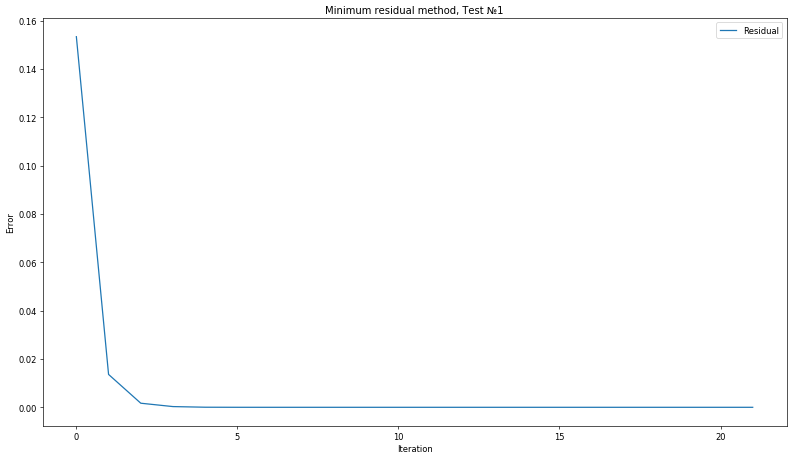

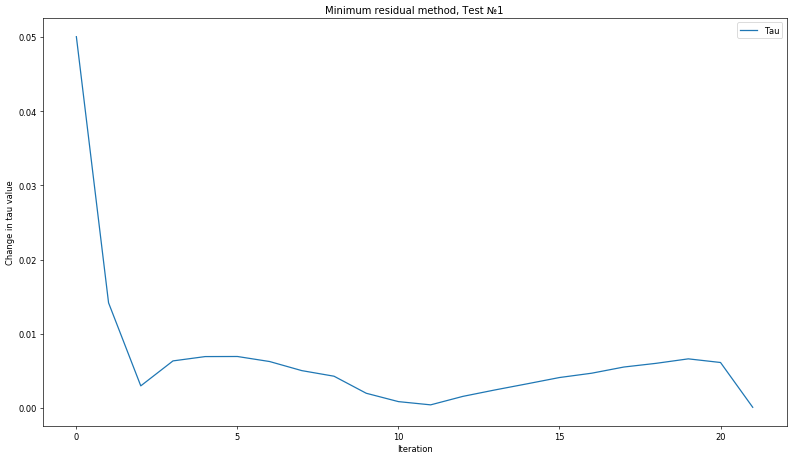

Test №2, maxtrix with a ratio np.average(np.diag(A)) << n:
[ 0.09957049  0.41209829 -0.29752953 -0.16077611 -0.02060502 -0.0633309
  0.11524275 -0.43922279  0.55851785  0.30100345]


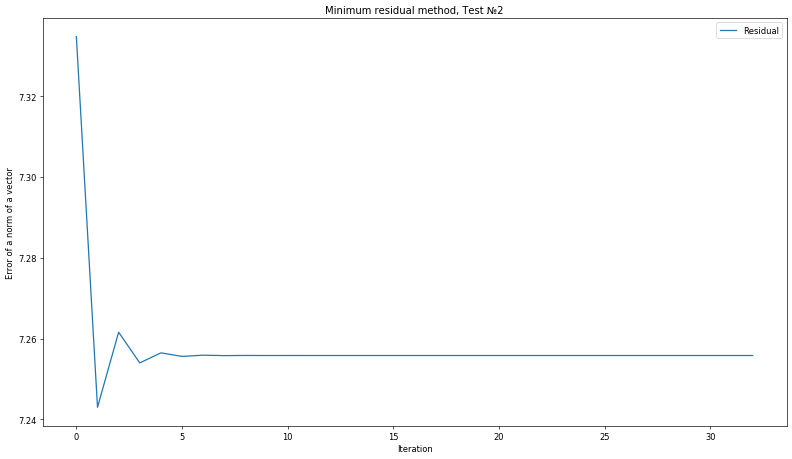

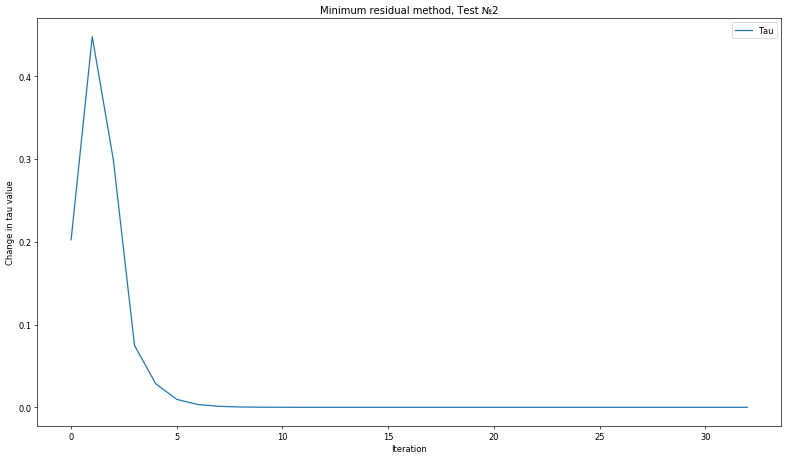

In [22]:
import matplotlib.pyplot as plt

def minres(A, b, eps = 1e-15, max_iter = np.inf):
    #----------------------------------
    r_sol = np.linalg.inv(A) @ b 
    #----------------------------------
    #Setting up initial elements
    x = np.ones_like(b)
    iterc = 0
    a_tol = True
    tau = 0
    
    while a_tol and iterc < max_iter:
        #Computing a residual
        res = A @ x - b
        #Minimizing res_(n+1) @ res_(n+1)
        delta = A @ res
        tau0 = tau
        tau = delta @ res / (delta @ delta)
        #Computing new x
        x -= tau * res
        #Computing residual for a new x to compare with an old one
        res0 = A @ x - b
        
        #Chekcing tolerance
        a_tol = np.linalg.norm(res - res0) > eps
        iterc += 1
        #----------------------------------
        tau_dif.append(np.linalg.norm(tau0 - tau))
        sol_dif.append(np.linalg.norm(x - r_sol))
        #----------------------------------
        
    return x

np.set_printoptions(suppress=True)

sol_dif = []
tau_dif = []

#Test №1
n = 10
A = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b = rndm.uniform(size=n)
print("Test №1, maxtrix with a ratio np.average(np.diag(A)) ~ or >> n:")
print(A @ minres(A, b) - b)

plt.figure(figsize=(16, 9), dpi= 60, facecolor='w', edgecolor='k')
plt.title('Minimum residual method, Test №1')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.plot(range(len(sol_dif)), sol_dif, label='Residual')
plt.legend()

plt.figure(figsize=(16, 9), dpi= 60, facecolor='w', edgecolor='k')
plt.title('Minimum residual method, Test №1')
plt.xlabel('Iteration')
plt.ylabel('Change in tau value')
plt.plot(range(len(tau_dif)), tau_dif, label='Tau')
plt.legend()

plt.show()

sol_dif = []
tau_dif = []

#Test №2
n = 10
A = rndm.uniform(size=(n, n))
b = rndm.uniform(size=n)
print("Test №2, maxtrix with a ratio np.average(np.diag(A)) << n:")
print(A @ minres(A, b) - b)

plt.figure(figsize=(16, 9), dpi= 60, facecolor='w', edgecolor='k')
plt.title('Minimum residual method, Test №2')
plt.xlabel('Iteration')
plt.ylabel('Error of a norm of a vector')
plt.plot(range(len(sol_dif)), sol_dif, label='Residual')
plt.legend()

plt.figure(figsize=(16, 9), dpi= 60, facecolor='w', edgecolor='k')
plt.title('Minimum residual method, Test №2')
plt.xlabel('Iteration')
plt.ylabel('Change in tau value')
plt.plot(range(len(tau_dif)), tau_dif, label='Tau')
plt.legend()
plt.show()

Test №3, maxtrix with a ratio np.average(np.diag(A)) ~ n:
[-0. -0.  0.  0.  0. -0. -0.  0. -0.  0. -0.  0.]


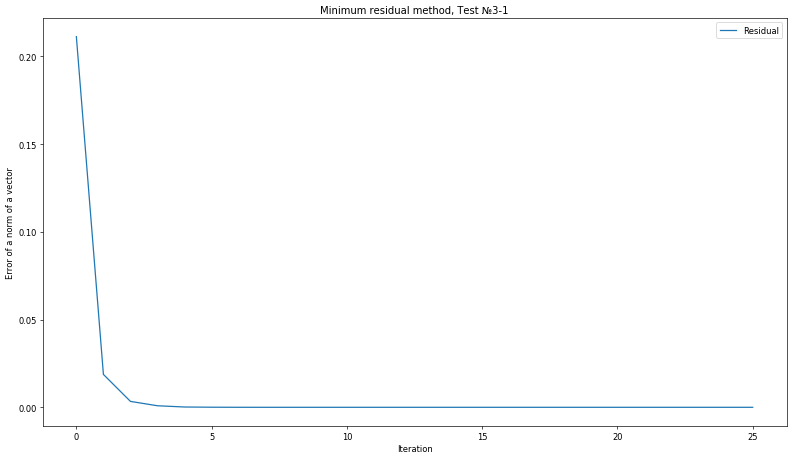

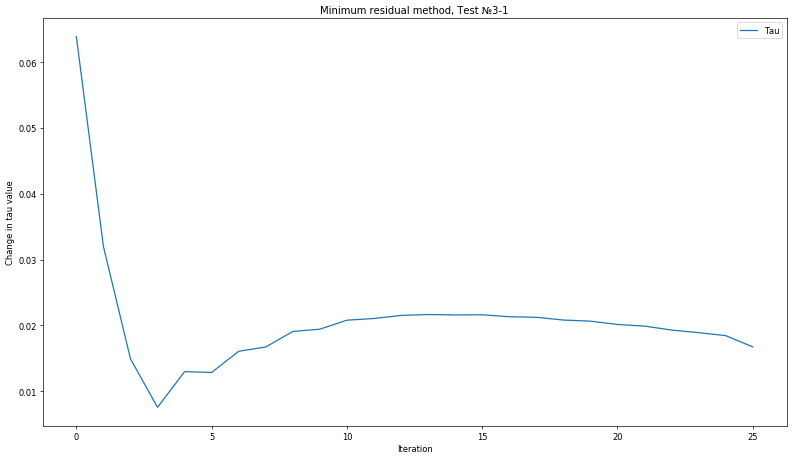

Test №3, maxtrix with a ratio np.average(np.diag(A)) << n:
[ 0.  0. -0.  0. -0. -0. -0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.
  0. -0. -0. -0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 -0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0. -0.
  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0. -0.  0.  0. -0.  0.  0. -0.  0. -0.  0.  0. -0.
  0.  0.  0. -0.  0.  0.  0. -0.  0.  0.]


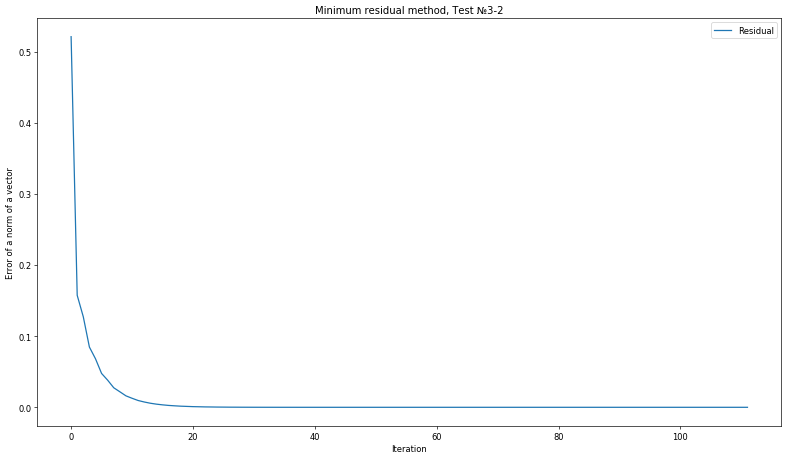

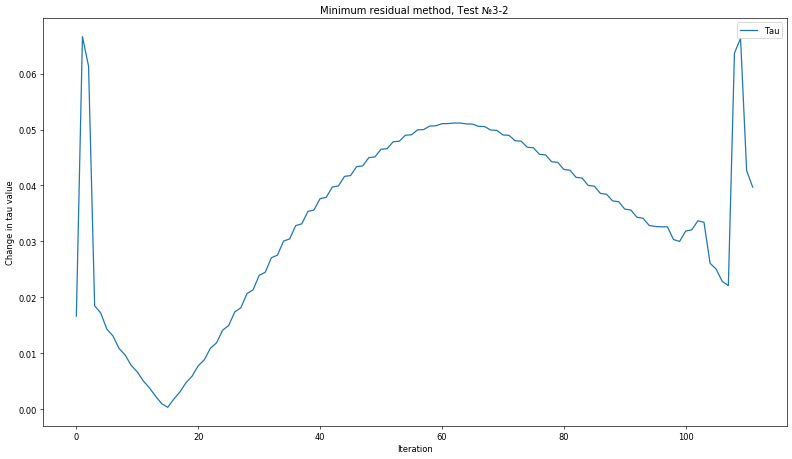

In [23]:
sol_dif = []
tau_dif = []

#Test №3
n = 12
A = rndm.uniform(size=(n, n)) + np.diagflat([10]*n)
b = rndm.uniform(size=n)
print("Test №3, maxtrix with a ratio np.average(np.diag(A)) ~ n:")
print(A @ minres(A, b) - b)

plt.figure(figsize=(16, 9), dpi= 60, facecolor='w', edgecolor='k')
plt.title('Minimum residual method, Test №3-1')
plt.xlabel('Iteration')
plt.ylabel('Error of a norm of a vector')
plt.plot(range(len(sol_dif)), sol_dif, label='Residual')
plt.legend()

plt.figure(figsize=(16, 9), dpi= 60, facecolor='w', edgecolor='k')
plt.title('Minimum residual method, Test №3-1')
plt.xlabel('Iteration')
plt.ylabel('Change in tau value')
plt.plot(range(len(tau_dif)), tau_dif, label='Tau')
plt.legend()

plt.show()

sol_dif = []
tau_dif = []

n = 100
A = rndm.uniform(size=(n, n)) + np.diagflat([10]*n)
b = rndm.uniform(size=n)
print("Test №3, maxtrix with a ratio np.average(np.diag(A)) << n:")
print(A @ minres(A, b) - b)

plt.figure(figsize=(16, 9), dpi= 60, facecolor='w', edgecolor='k')
plt.title('Minimum residual method, Test №3-2')
plt.xlabel('Iteration')
plt.ylabel('Error of a norm of a vector')
plt.plot(range(len(sol_dif)), sol_dif, label='Residual')
plt.legend()

plt.figure(figsize=(16, 9), dpi= 60, facecolor='w', edgecolor='k')
plt.title('Minimum residual method, Test №3-2')
plt.xlabel('Iteration')
plt.ylabel('Change in tau value')
plt.plot(range(len(tau_dif)), tau_dif, label='Tau')
plt.legend()

plt.show()